# HW5
赵心怡 19307110452 


In [11]:
import numpy as np
from matplotlib import pyplot as plt
import cv2
from copy import deepcopy
import random
import itertools

In [12]:
# problem 1
# k-means 算法
def k_means(img, k, threshold):
    maxvalue = np.max(img)   # 局部区域的灰度值范围
    minvalue = np.min(img)
    init_center = random.sample(range(minvalue,maxvalue + 1), k) # 随机生成k个初始中心
    init_center.sort()
    current_center = init_center
    classmatrix = center_classify(img, init_center) # 初始各个像素的分类
    while True:
        last_center = current_center.copy() # 上一步聚类中心
        for each_class in range(k):
            this_class_pixel = img[np.where(classmatrix == each_class)] # 对每一类找到对应的像素点
            current_center[each_class] = sum(this_class_pixel) / len(this_class_pixel) # 算平均值更新新的聚类中心
        new_class = center_classify(img, current_center) # 根据新的聚类中心得到每个像素点新的类别
        if np.sum((np.array(current_center) - np.array(last_center))**2) <= threshold**2:
            break               # 如果两次聚类中心欧式距离和小于阈值则不再迭代
        classmatrix = new_class # 否则继续更新，把当前得到的新的聚类给下一步
    new_img = (new_class * 255/ (k-1)).astype(np.uint8)
    return new_img


def center_classify(img, center_list):
    height, width = img.shape
    classmatrix = np.zeros((height, width)) # 类别矩阵
    distance = []
    for (i,j) in itertools.product(range(height), range(width)):
        for k in range(len(center_list)):
            each_dist = np.sum((img[i][j] - center_list[k]) ** 2)
            distance.append(each_dist) # 计算当前像素点到每个聚类中心的距离
        classmatrix[i][j] = np.argmin(distance) # 算出距离最短的类别
        distance = [] # 置空方便下一个像素点使用
    return classmatrix

In [13]:
def OSTU(img):
    maxvalue = np.max(img)   # 局部区域的灰度值范围
    minvalue = np.min(img)
    criterion_value = np.zeros(256)
    for threshold in range(minvalue,maxvalue+1):    # 移动阈值
        background = img[img < threshold]  # 背景
        weight_bg = background.size / img.size # 背景的概率
        mean_bg = background.mean() if background.size else 0  # 背景的均值
        foreground = img[img >= threshold] # 前景
        weight_fg = foreground.size / img.size #前景的概率
        mean_fg = foreground.mean() if foreground.size else 0 # 前景的均值
        criterion_value[threshold] = weight_bg * weight_fg * (mean_bg - mean_fg) ** 2   # 组间方差
    best_threshold = np.argmax(criterion_value) # 选择最大的值对应的灰度值作为最终阈值
    newImg = img > best_threshold
    return newImg * 255 # 得到最终图片

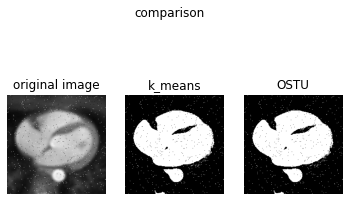

In [14]:
img = cv2.imread('newimg_leaf.jpg', cv2.IMREAD_GRAYSCALE) # 读入图片
a = 200 # 可调节参数
plt.clf()
newImg = k_means(img,2,1)
newImgOs = OSTU(img)
plt.suptitle(r'comparison')
plt.subplot(1, 3, 1), plt.imshow(img, cmap="gray")
plt.axis("off"), plt.title("original image")
plt.subplot(1, 3, 2), plt.imshow(newImg, cmap="gray")
plt.axis("off"), plt.title("k_means")
plt.subplot(1, 3, 3), plt.imshow(newImgOs, cmap="gray")
plt.axis("off"), plt.title("OSTU")
# plt.savefig("new_k_means_2.jpg")
plt.show()
# cv2.imwrite('new_k_means_2.jpg', newImg)

((-0.5, 223.5, 223.5, -0.5), Text(0.5, 1.0, 'k = 4'))

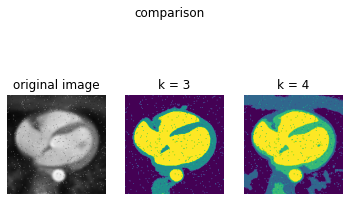

In [15]:
# test three or more categories
img = cv2.imread('newimg_leaf.jpg', cv2.IMREAD_GRAYSCALE) # 读入图片
plt.clf()
newImg3 = k_means(img,3,1)
newImg4 = k_means(img, 4, 1)
plt.suptitle(r'comparison')
plt.subplot(1, 3, 1), plt.imshow(img, cmap="gray")
plt.axis("off"), plt.title("original image")
plt.subplot(1, 3, 2), plt.imshow(newImg3)
plt.axis("off"), plt.title("k = 3")
plt.subplot(1, 3, 3), plt.imshow(newImg4)
plt.axis("off"), plt.title("k = 4")

In [16]:
# Problem 2

def dilate(img,time):#膨胀操作
    height,width = img.shape
    kernel = np.array(((0,0,1,0,0),(0,1,1,1,0),(1,1,1,1,1),(0,1,1,1,0),(0,0,1,0,0)))#选择核
    # 对卷积次数
    img_new = img.copy()
    for i in range(time):#膨胀次数
        tmp = np.pad(img_new, (2, 2), 'edge') #扩张图片
        for y in range(2, height+2):
            for x in range(2, width+2):
                if np.sum(kernel * tmp[y-2:y+3, x-2:x+3]) >= 255: # 原图片5*5范围内有无白色块，该像素点就是白的
                    img_new[y-2, x-2] = 255
    return img_new
    


def erode(img, time):#腐蚀操作
    height, width = img.shape
    kernel = np.array(((0,0,1,0,0),(0,1,1,1,0),(1,1,1,1,1),(0,1,1,1,0),(0,0,1,0,0)))
    # each dilate time
    img_new = img.copy()
    for i in range(time):#腐蚀次数
        tmp = np.pad(img_new, (2, 2), 'edge') #扩展图片
        for y in range(2, height+2):
            for x in range(2, width+2):
                if np.sum(kernel * tmp[y-2:y+3, x-2:x+3]) < 255*12: #原图5*5范围有无黑色块，该像素点就是黑的
                    img_new[y-2, x-2] = 0
    return img_new


def open(img, time):#先腐蚀再膨胀
    newImg = erode(img, time)
    newImg = dilate(newImg, time)
    return newImg
 
def close(img,time):#先膨胀再腐蚀
    newImg = dilate(img, time=time)
    newImg = erode(newImg, time=time)
    return newImg


True

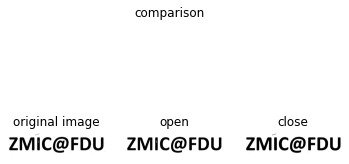

In [17]:
# test three or more categories
img = cv2.imread('fdu.jpg', cv2.IMREAD_GRAYSCALE) # 读入图片
plt.clf()
newImg3 = 255-open(255-img,1)
newImg4 = 255-close(255-img,1)
plt.suptitle(r'comparison')
plt.subplot(1, 3, 1), plt.imshow(img, cmap="gray")
plt.axis("off"), plt.title("original image")
plt.subplot(1, 3, 2), plt.imshow(newImg3,cmap="gray")
plt.axis("off"), plt.title("open")
cv2.imwrite('open.jpg', newImg3)
plt.subplot(1, 3, 3), plt.imshow(newImg4,cmap="gray")
plt.axis("off"), plt.title("close")
cv2.imwrite('close.jpg', newImg4)

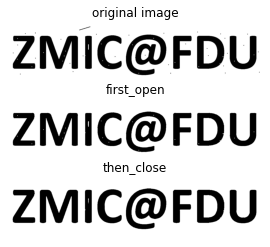

In [18]:
img = cv2.imread('fdu.jpg', cv2.IMREAD_GRAYSCALE) # 读入图片
plt.clf()
# plt.suptitle(r'comparison')
newImg3 = 255-open(255-img,1)
newImg4 = 255-close(255-newImg3,1)
plt.subplot(3, 1, 1), plt.imshow(img, cmap="gray")
plt.axis("off"), plt.title("original image")
plt.subplot(3, 1, 2), plt.imshow(newImg3,cmap="gray")
plt.axis("off"), plt.title("first_open")
cv2.imwrite('open1.jpg', newImg3)
plt.subplot(3, 1, 3), plt.imshow(newImg4,cmap="gray")
plt.axis("off"), plt.title("then_close")
cv2.imwrite('close2.jpg', newImg4)
plt.savefig('new')
